<a href="https://colab.research.google.com/github/DinurakshanRavichandran/Visio-Glance/blob/OCT-eye-disease-detection/CourseworkModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 1

## Preprocessing and pipeline

1. Set Up Your Environment

In [ ]:
# Core Libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight

# For reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("Environment ready!")


Environment ready!


In [ ]:
import zipfile

# Path to the zipped dataset in your Drive
zip_path = '/content/drive/MyDrive/Machine learning/Dataset/OCT Dataset/Train/archive.zip'

# Set extraction path in Colab
extract_path = '/content/OCT_Dataset'

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")



Dataset unzipped successfully!


2. Data Preparation

In [ ]:
import os
import random
import shutil

def limit_images_per_class(src_dir, dest_dir, max_images=8000):
    """
    Copies a limited number of images from source to destination for each class.
    Parameters:
        src_dir (str): Source directory where the images are stored.
        dest_dir (str): Destination directory to store the limited images.
        max_images (int): Maximum number of images per class.
    """
    # Ensure destination directory exists
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Iterate through each class folder in the source directory
    for category in os.listdir(src_dir):
        category_path = os.path.join(src_dir, category)
        dest_category_path = os.path.join(dest_dir, category)

        if not os.path.exists(dest_category_path):
            os.makedirs(dest_category_path)

        # Get list of images
        images = [
            os.path.join(category_path, img)
            for img in os.listdir(category_path)
            if img.endswith(('.jpeg', '.jpg', '.png'))
        ]

        # Shuffle and select limited images
        random.shuffle(images)
        limited_images = images[:max_images]

        # Copy limited images to destination folder
        for img_path in limited_images:
            shutil.copy(img_path, os.path.join(dest_category_path, os.path.basename(img_path)))

# Source and destination paths
src_train_dir = '/content/OCT_Dataset/OCT2017 /train'
dest_train_dir = '/content/OCT_Dataset/OCT2017 /train_limited'

# Apply the function
limit_images_per_class(src_train_dir, dest_train_dir, max_images=8000)

print("Training data limited to 8,000 images per class.")


Training data limited to 8,000 images per class.


In [ ]:
train_dir = '/content/OCT_Dataset/OCT2017 /train_limited'
val_dir = '/content/OCT_Dataset/OCT2017 /val'
test_dir = '/content/OCT_Dataset/OCT2017 /test'


Define Data Generators

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Preprocess grayscale images to RGB
def preprocess_grayscale_to_rgb(image):
    """
    Converts a grayscale image to RGB and applies normalization for EfficientNet.
    """
    image = tf.image.decode_jpeg(image, channels=1)  # Decode as grayscale
    image = tf.image.resize(image, [224, 224])      # Resize to target dimensions
    image = tf.image.grayscale_to_rgb(image)        # Convert grayscale to RGB
    image = tf.keras.applications.efficientnet.preprocess_input(image)  # Normalize for EfficientNet
    return image

# Wrap function for use in ImageDataGenerator
def grayscale_to_rgb_preprocessing_function(image_path):
    image = tf.io.read_file(image_path)
    return preprocess_grayscale_to_rgb(image)

# Create data generators
def create_data_generators_with_grayscale_conversion(train_dir, val_dir, test_dir, img_height=224, img_width=224, batch_size=32):
    """
    Creates data generators with grayscale-to-RGB conversion and augmentations.

    Parameters:
        train_dir (str): Path to the training directory.
        val_dir (str): Path to the validation directory.
        test_dir (str): Path to the testing directory.
        img_height (int): Target image height (default: 224).
        img_width (int): Target image width (default: 224).
        batch_size (int): Batch size for generators (default: 32).

    Returns:
        tuple: (train_generator, val_generator, test_generator)
    """
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=grayscale_to_rgb_preprocessing_function  # Apply grayscale-to-RGB preprocessing
    )

    # Validation and testing data generators (only normalization)
    val_test_datagen = ImageDataGenerator(preprocessing_function=grayscale_to_rgb_preprocessing_function)

    # Training data generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,                  # Training directory
        target_size=(img_height, img_width),  # Resize images
        batch_size=batch_size,      # Batch size
        class_mode='categorical'    # For multi-class classification
    )

    # Validation data generator
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,                    # Validation directory
        target_size=(img_height, img_width),  # Resize images
        batch_size=batch_size,      # Batch size
        class_mode='categorical'    # For multi-class classification
    )

    # Test data generator
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,                   # Testing directory
        target_size=(img_height, img_width),  # Resize images
        batch_size=batch_size,      # Batch size
        class_mode='categorical'    # For multi-class classification
    )

    print("Data generators with grayscale conversion created successfully.")
    return train_generator, val_generator, test_generator

# Paths to dataset
train_dir = '/content/OCT_Dataset/OCT2017 /train'
val_dir = '/content/OCT_Dataset/OCT2017 /val'
test_dir = '/content/OCT_Dataset/OCT2017 /test'

# Generate the data generators
train_generator, val_generator, test_generator = create_data_generators_with_grayscale_conversion(train_dir, val_dir, test_dir)


Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Data generators with grayscale conversion created successfully.


## Train individual models

4. Train Individual Models

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers

def fine_tune_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze some layers for fine-tuning
    base_model.trainable = True
    for layer in base_model.layers[:200]:  # Freeze first 200 layers (adjustable)
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Dropout for regularization
    output = layers.Dense(4, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)

    # Compile with a lower learning rate
    optimizer = optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

efficientnet_model = fine_tune_efficientnet()
history_efficientnet = efficientnet_model.fit(train_generator, validation_data=val_generator, epochs=12)
efficientnet_model.save('fine_tuned_efficientnet.h5')



ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

def fine_tune_resnet():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze last few layers for fine-tuning
    for layer in base_model.layers[:143]:  # Freeze first 143 layers (adjustable)
        layer.trainable = False
    for layer in base_model.layers[143:]:
        layer.trainable = True

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Dropout for regularization
    output = layers.Dense(4, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)

    # Compile with a low learning rate for fine-tuning
    optimizer = optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_model = fine_tune_resnet()
history_resnet = resnet_model.fit(train_generator, validation_data=val_generator, epochs=12)
resnet_model.save('fine_tuned_resnet.h5')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 592s 564ms/step - accuracy: 0.3914 - loss: 1.2745 - val_accuracy: 0.3125 - val_loss: 5.8072
Epoch 2/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 578s 575ms/step - accuracy: 0.5320 - loss: 1.0769 - val_accuracy: 0.5938 - val_loss: 0.9632
Epoch 3/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 616s 568ms/step - accuracy: 0.5742 - loss: 0.9895 - val_accuracy: 0.4375 - val_loss: 1.4035
Epoch 4/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 610s 557ms/step - accuracy: 0.6012 - loss: 0.9422 - val_accuracy: 0.5312 - val_loss: 1.0157
Epoch 5/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 558s 554ms/step - accuracy: 0.6258 - loss: 0.8929 - val_accuracy: 0.5938 - val_loss: 1.8408
Epoch 6/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 555s 548ms/step - accuracy: 0.6385 - loss: 0.8729 - val_accuracy: 0.8125 - val_loss: 0.6564
Epoch 7/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 570s 556ms/step - accuracy: 0.6526 - loss: 0.8380 - val_accuracy: 0.6562 - val_loss: 0.8641
Epoch 8/12


In [ ]:
from tensorflow.keras.applications import DenseNet121

def create_densenet():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

densenet_model = create_densenet()
history_densenet = densenet_model.fit(train_generator, validation_data=val_generator, epochs=12)
densenet_model.save('densenet_model.h5')


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 661s 627ms/step - accuracy: 0.6589 - loss: 0.8312 - val_accuracy: 0.9062 - val_loss: 0.3138
Epoch 2/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 647s 608ms/step - accuracy: 0.7702 - loss: 0.6000 - val_accuracy: 0.9062 - val_loss: 0.3083
Epoch 3/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 620s 606ms/step - accuracy: 0.7847 - loss: 0.5611 - val_accuracy: 0.9062 - val_loss: 0.2697
Epoch 4/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 613s 599ms/step - accuracy: 0.7859 - loss: 0.5491 - val_accuracy: 0.8438 - val_loss: 0.3913
Epoch 5/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 604s 599ms/step - accuracy: 0.7971 - loss: 0.5278 - val_accuracy: 0.9375 - val_loss: 0.2154
Epoch 6/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 618s 597ms/step - accuracy: 0.7963 - loss: 0.5368 - val_accuracy: 0.8750 - val_loss: 0.2852
Epoch 7/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 614s 608ms/step - accuracy: 0.8041 - loss: 0.5105 - val_accuracy: 0.9062 - val_loss: 0.2050
Epoch 8/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 603s 592ms/step - accuracy: 0.8

In [ ]:
# Assuming you have your test_generator defined as before
test_loss, test_accuracy = densenet_model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 449ms/step - accuracy: 0.9426 - loss: 0.1915
Test Loss: 0.1857
Test Accuracy: 0.9432


5. Create and Train the Ensemble

In [ ]:
# Load trained models
efficientnet_model = load_model('fine_tuned_efficientnet.h5')
resnet_model = load_model('fine_tuned_resnet.h5')
densenet_model = load_model('densenet_model.h5')

# Freeze all models
for model in [efficientnet_model, resnet_model, densenet_model]:
    model.trainable = False

# Create ensemble output
efficientnet_output = efficientnet_model.output
resnet_output = resnet_model.output
densenet_output = densenet_model.output

ensemble_output = Average()([efficientnet_output, resnet_output, densenet_output])

# Create ensemble model
ensemble_model = Model(
    inputs=[efficientnet_model.input, resnet_model.input, densenet_model.input],
    outputs=ensemble_output
)

ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ensemble (optional fine-tuning)
history_ensemble = ensemble_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

ensemble_model.save('ensemble_model.h5')


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'efficientnet_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Evaluate the Ensemble

In [ ]:
test_loss, test_accuracy = ensemble_model.evaluate(test_generator)
print(f"Ensemble Test Accuracy: {test_accuracy:.2f}")

# Model 2

## Preprocessing and Data pipeline

Environment Setup

In [1]:
# Core Libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight

# For reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("Environment ready!")


Environment ready!


Unzipping the dataset

In [2]:
import zipfile

# Path to the zipped dataset in your Drive
zip_path = '/content/drive/MyDrive/Machine learning/Dataset/OCT Dataset/Train/archive.zip'

# Set extraction path in Colab
extract_path = '/content/OCT_Dataset'

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")


Dataset unzipped successfully!


Limiting images per class

In [3]:
import os
import random
import shutil

def limit_images_per_class(src_dir, dest_dir, max_images=8000):
    """
    Copies a limited number of images from source to destination for each class.
    Parameters:
        src_dir (str): Source directory where the images are stored.
        dest_dir (str): Destination directory to store the limited images.
        max_images (int): Maximum number of images per class.
    """
    # Ensure destination directory exists
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Iterate through each class folder in the source directory
    for category in os.listdir(src_dir):
        category_path = os.path.join(src_dir, category)
        dest_category_path = os.path.join(dest_dir, category)

        if not os.path.exists(dest_category_path):
            os.makedirs(dest_category_path)

        # Get list of images
        images = [
            os.path.join(category_path, img)
            for img in os.listdir(category_path)
            if img.endswith(('.jpeg', '.jpg', '.png'))
        ]

        # Shuffle and select limited images
        random.shuffle(images)
        limited_images = images[:max_images]

        # Copy limited images to destination folder
        for img_path in limited_images:
            shutil.copy(img_path, os.path.join(dest_category_path, os.path.basename(img_path)))

# Source and destination paths
src_train_dir = '/content/OCT_Dataset/OCT2017 /train'
dest_train_dir = '/content/OCT_Dataset/OCT2017 /train_limited'

# Apply the function
limit_images_per_class(src_train_dir, dest_train_dir, max_images=8000)

print("Training data limited to 8,000 images per class.")


Training data limited to 8,000 images per class.


Setting paths for training, testing and validation.

In [4]:
train_dir = '/content/OCT_Dataset/OCT2017 /train_limited'
val_dir = '/content/OCT_Dataset/OCT2017 /val'
test_dir = '/content/OCT_Dataset/OCT2017 /test'


Pre processing and creating data generators

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess grayscale images to RGB
def preprocess_grayscale_to_rgb(image):
    """
    Converts a grayscale NumPy array to RGB and applies normalization for EfficientNet.
    """
    # Check if the image is already RGB
    if image.shape[-1] == 3:
        # If already RGB, skip the conversion
        image = tf.image.resize(image, [224, 224])
    else:
        if len(image.shape) == 2:  # If grayscale, add channel dimension
            image = tf.expand_dims(image, axis=-1)  # Add channel dimension
        image = tf.image.resize(image, [224, 224])  # Resize to target dimensions
        image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB
    image = tf.keras.applications.efficientnet.preprocess_input(image)  # Normalize for EfficientNet
    return image


# Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_grayscale_to_rgb  # Use updated function
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_grayscale_to_rgb)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',  # Ensure grayscale input
    class_mode='categorical'
)

# Validation data generator
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

# Testing data generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False  # Maintain order for evaluation
)

print("Data generators configured with grayscale-to-RGB conversion.")


Found 32000 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Data generators configured with grayscale-to-RGB conversion.


## Individual model training and testing

### Model Training

EfficientNetB0 Model

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers

def fine_tune_efficientnet():
    """
    Fine-tunes EfficientNetB0 with a frozen base and custom classification head.
    """
    # Load EfficientNetB0 with pre-trained ImageNet weights
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the first 200 layers
    for layer in base_model.layers[:200]:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)  # Global pooling
    x = layers.Dense(512, activation='relu')(x)  # Fully connected layer
    x = layers.Dropout(0.5)(x)  # Dropout for regularization
    output = layers.Dense(4, activation='softmax')(x)  # Output layer for 4 classes

    # Create the model
    model = models.Model(inputs=base_model.input, outputs=output)

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Instantiate the model
efficientnet_model = fine_tune_efficientnet()

# Train the model using the data generator
history_efficientnet = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=12
)

# Save the trained model
efficientnet_model.save('efficientnet.h5')

# Output message for clarity
print("EfficientNetB0 model trained and saved successfully.")


Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 643s 601ms/step - accuracy: 0.7224 - loss: 0.6850 - val_accuracy: 0.9688 - val_loss: 0.0617
Epoch 2/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 576s 573ms/step - accuracy: 0.8726 - loss: 0.3492 - val_accuracy: 0.9688 - val_loss: 0.0431
Epoch 3/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 571s 568ms/step - accuracy: 0.8901 - loss: 0.3053 - val_accuracy: 1.0000 - val_loss: 0.0296
Epoch 4/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 566s 563ms/step - accuracy: 0.8990 - loss: 0.2800 - val_accuracy: 0.9688 - val_loss: 0.0943
Epoch 5/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 624s 565ms/step - accuracy: 0.9028 - loss: 0.2671 - val_accuracy: 0.9688 - val_loss: 0.0782
Epoch 6/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 559s 554ms/step - accuracy: 0.9097 - loss: 0.2532 - val_accuracy: 0.9688 - val_loss: 0.0414
Epoch 7/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 564s 561ms/step - accuracy: 0.9132 - loss: 0.2387 - val_accuracy: 1.0000 - val_loss: 0.0590
Epoch 8/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 579s 576ms/step - accuracy: 0.9

EfficientNetB0 model trained and saved successfully.


ResNet50 model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

def fine_tune_resnet():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:143]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(4, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_model = fine_tune_resnet()
history_resnet = resnet_model.fit(train_generator, validation_data=val_generator, epochs=12)
resnet_model.save('resnet.h5')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 603s 576ms/step - accuracy: 0.7682 - loss: 0.5921 - val_accuracy: 0.9375 - val_loss: 0.0979
Epoch 2/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 560s 558ms/step - accuracy: 0.8891 - loss: 0.3179 - val_accuracy: 0.9688 - val_loss: 0.0545
Epoch 3/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 556s 553ms/step - accuracy: 0.9030 - loss: 0.2798 - val_accuracy: 0.9688 - val_loss: 0.0498
Epoch 4/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 561s 558ms/step - accuracy: 0.9098 - loss: 0.2565 - val_accuracy: 0.9688 - val_loss: 0.0728
Epoch 5/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 565s 563ms/step - accuracy: 0.9191 - loss: 0.2329 - val_accuracy: 0.9688 - val_loss: 0.0586
Epoch 6/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 563s 559ms/step - accuracy: 0.9198 - loss: 0.2311 - val_accuracy: 0.9375 - val_loss: 0.1124
Epoch 7/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 626s 565ms/step - accuracy: 0.9252 - loss: 0.2124 - val_accuracy: 1.0000 - val_loss: 0.0264
Epoch 8/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 614s 557ms/step - accuracy: 0.9

Dense Net model

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def create_densenet():
    # Load DenseNet121 with ImageNet weights
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze the last 30 layers for fine-tuning
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    # Add custom layers on top
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Increased dropout for regularization
    x = layers.Dense(512, activation='relu')(x)  # Increased units in dense layer
    x = layers.Dropout(0.3)(x)  # Additional dropout layer
    output = layers.Dense(4, activation='softmax')(x)  # Output layer for 4 classes

    # Compile the model
    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Compute class weights for handling imbalances
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

# Create the DenseNet model
densenet_model = create_densenet()

# Train the model with class weights
history_densenet = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=12,
    class_weight=class_weights_dict
)

# Save the trained model
densenet_model.save('densenet_model.h5')

# Output message
print("DenseNet model trained and saved successfully.")


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 999s 808ms/step - accuracy: 0.7504 - loss: 0.6517 - val_accuracy: 0.9688 - val_loss: 0.0560
Epoch 2/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 827s 777ms/step - accuracy: 0.9284 - loss: 0.2161 - val_accuracy: 0.9688 - val_loss: 0.0302
Epoch 3/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 773s 770ms/step - accuracy: 0.9335 - loss: 0.1941 - val_accuracy: 0.9688 - val_loss: 0.1045
Epoch 4/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 773s 768ms/step - accuracy: 0.9449 - loss: 0.1678 - val_accuracy: 1.0000 - val_loss: 0.0311
Epoch 5/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 774s 770ms/step - accuracy: 0.9501 - loss: 0.1516 - val_accuracy: 1.0000 - val_loss: 0.0118
Epoch 6/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 772s 769ms/step - accuracy: 0.9531 - loss: 0.1405 - val_accuracy: 1.0000 - val_loss: 0.0382
Epoch 7/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 774s 770ms/step - accuracy: 0.9531 - loss: 0.1451 - val_accuracy: 0.9688 - val_loss: 0.0314
Epoch 8/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 771s 767ms/step - accuracy: 0.9

DenseNet model trained and saved successfully.


### Model Evaluations

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define function to evaluate and compute metrics
def evaluate_model(model, generator, class_names):
    # Predict on test data
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes

    # Classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_names)
    print("Classification Report:\n", report)

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return report, cm


DenseNet Model Evaluation:


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 665ms/step
Classification Report:
               precision    recall  f1-score   support

         CNV       0.99      1.00      1.00       242
         DME       1.00      0.99      1.00       242
      DRUSEN       1.00      1.00      1.00       242
      NORMAL       1.00      1.00      1.00       242

    accuracy                           1.00       968
   macro avg       1.00      1.00      1.00       968
weighted avg       1.00      1.00      1.00       968



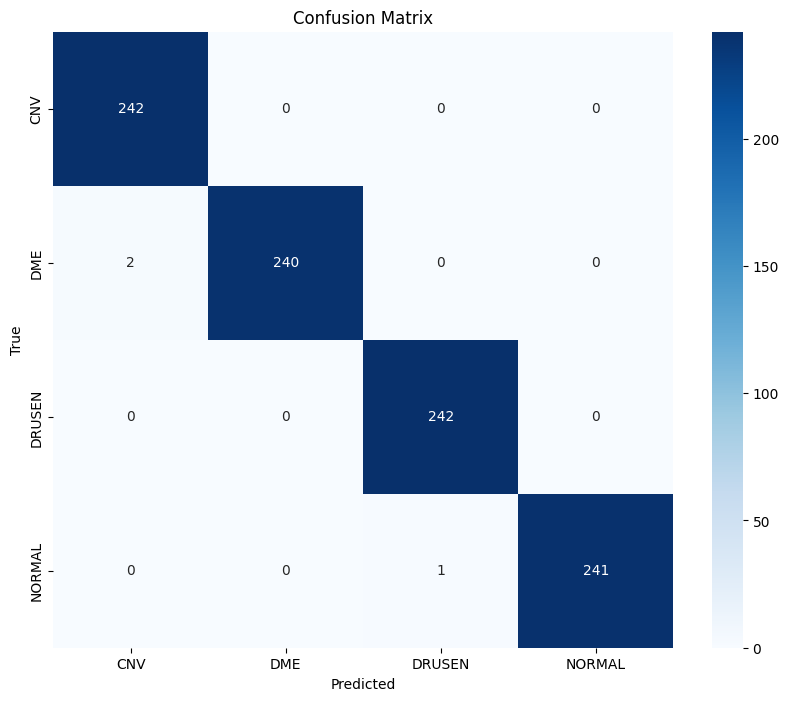


ResNet Model Evaluation:
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step
Classification Report:
               precision    recall  f1-score   support

         CNV       0.95      1.00      0.97       242
         DME       1.00      0.96      0.98       242
      DRUSEN       0.99      0.97      0.98       242
      NORMAL       0.99      1.00      0.99       242

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968



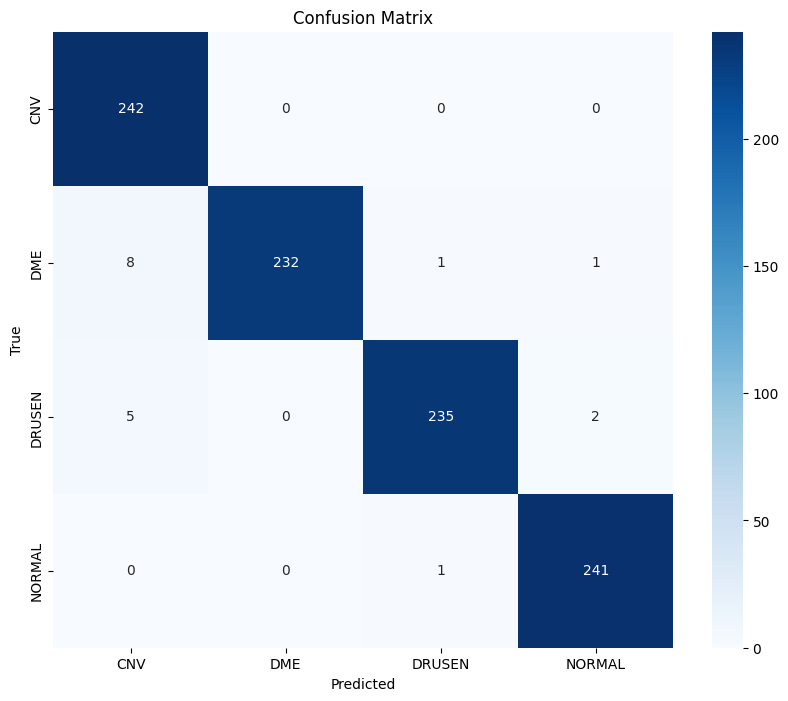


EfficientNet Model Evaluation:
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 505ms/step
Classification Report:
               precision    recall  f1-score   support

         CNV       1.00      1.00      1.00       242
         DME       1.00      1.00      1.00       242
      DRUSEN       0.98      1.00      0.99       242
      NORMAL       1.00      0.98      0.99       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



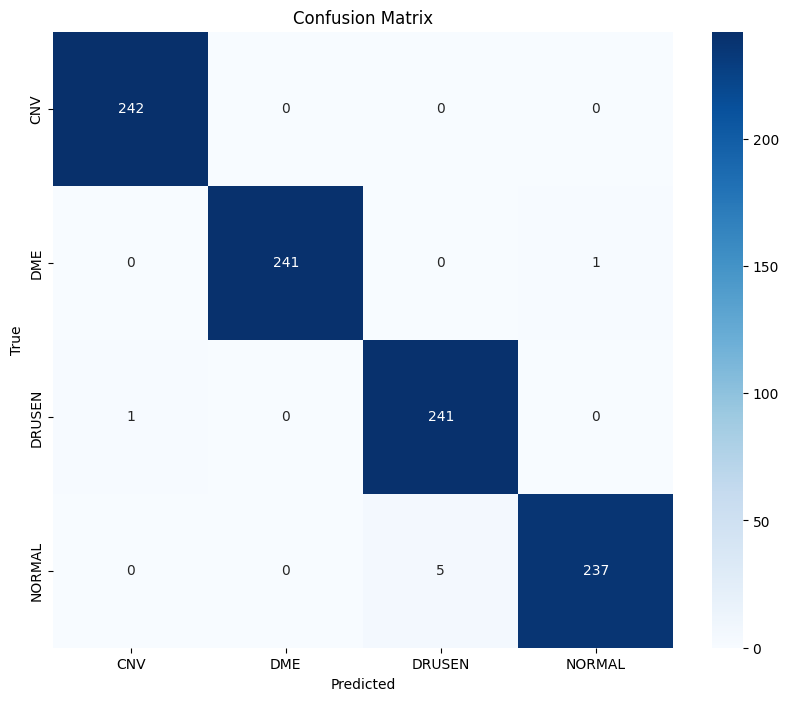

In [8]:
from tensorflow.keras.models import load_model

# Load models from their respective files
densenet_model = load_model('densenet_model.h5')
efficientnet_model = load_model('efficientnet.h5')
resnet_model = load_model('resnet.h5')

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Evaluate DenseNet model
print("DenseNet Model Evaluation:")
densenet_report, densenet_cm = evaluate_model(densenet_model, test_generator, class_labels)

# Evaluate ResNet model
print("\nResNet Model Evaluation:")
resnet_report, resnet_cm = evaluate_model(resnet_model, test_generator, class_labels)

# Evaluate EfficientNet model
print("\nEfficientNet Model Evaluation:")
efficientnet_report, efficientnet_cm = evaluate_model(efficientnet_model, test_generator, class_labels)


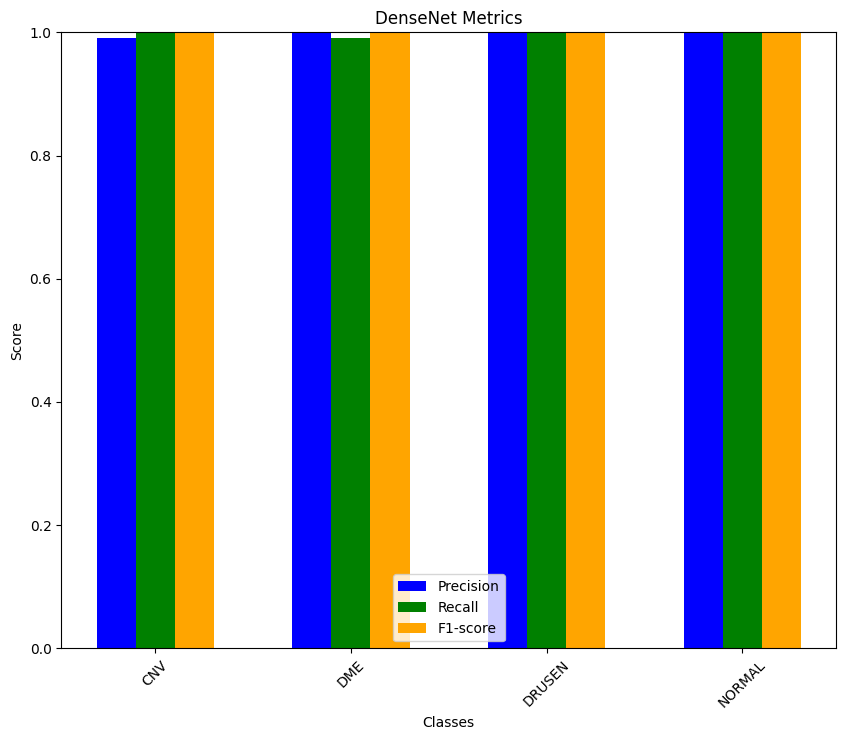

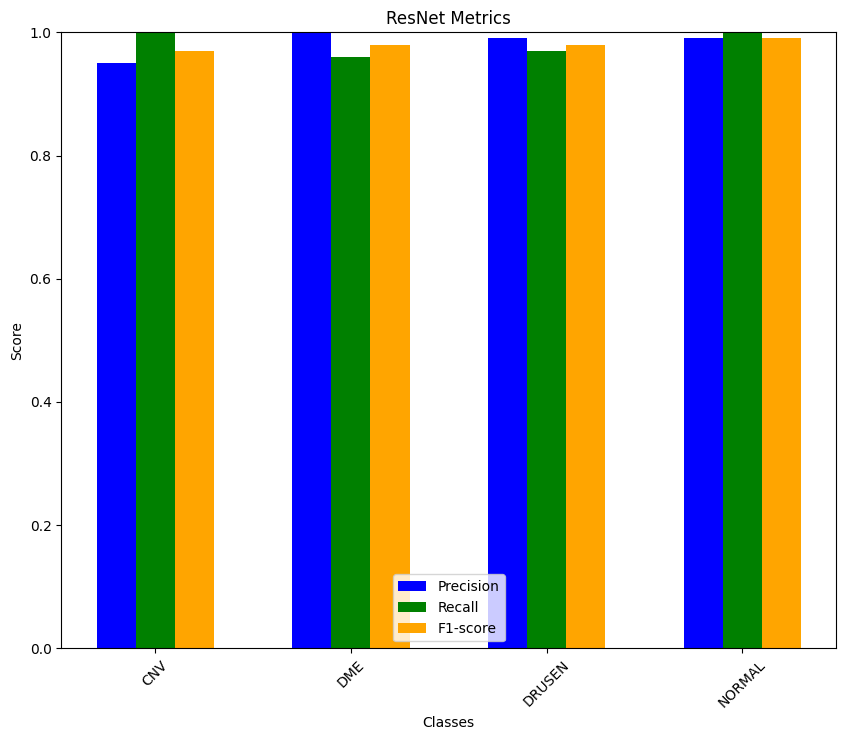

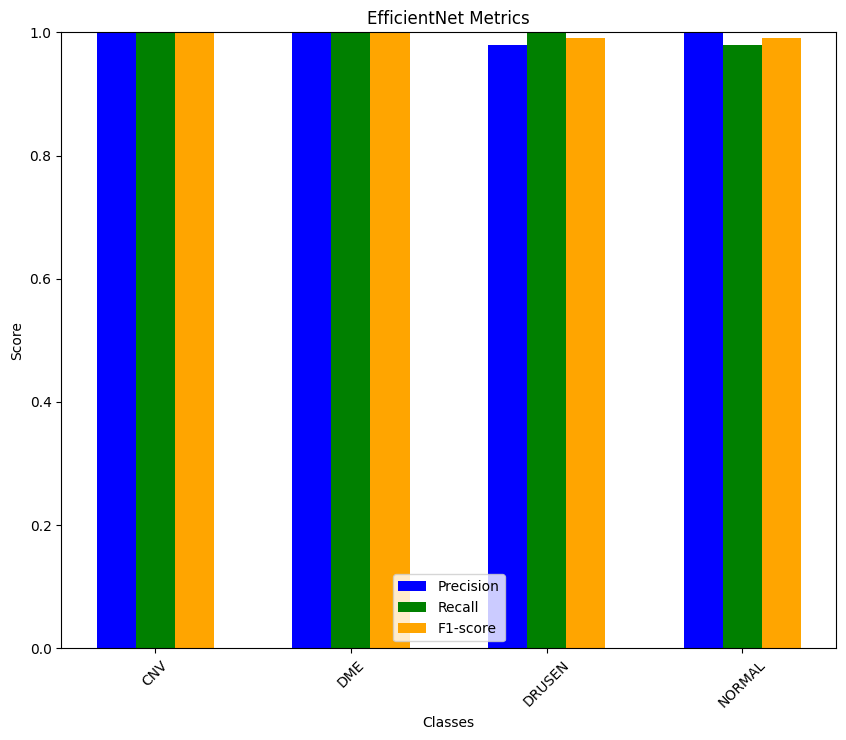

In [9]:
def plot_classification_report(report, title='Classification Metrics', figsize=(10, 8)):
    lines = report.split("\n")
    classes, precision, recall, f1_score, support = [], [], [], [], []

    for line in lines[2:(len(lines) - 5)]:
        row = line.split()
        classes.append(row[0])
        precision.append(float(row[1]))
        recall.append(float(row[2]))
        f1_score.append(float(row[3]))
        support.append(int(row[4]))

    x = np.arange(len(classes))

    plt.figure(figsize=figsize)
    plt.bar(x - 0.2, precision, width=0.2, label='Precision', color='blue')
    plt.bar(x, recall, width=0.2, label='Recall', color='green')
    plt.bar(x + 0.2, f1_score, width=0.2, label='F1-score', color='orange')

    plt.xticks(x, classes, rotation=45)
    plt.xlabel("Classes")
    plt.ylabel("Score")
    plt.title(title)
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

# Plot for DenseNet
plot_classification_report(densenet_report, title='DenseNet Metrics')

# Plot for ResNet
plot_classification_report(resnet_report, title='ResNet Metrics')

# Plot for EfficientNet
plot_classification_report(efficientnet_report, title='EfficientNet Metrics')


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


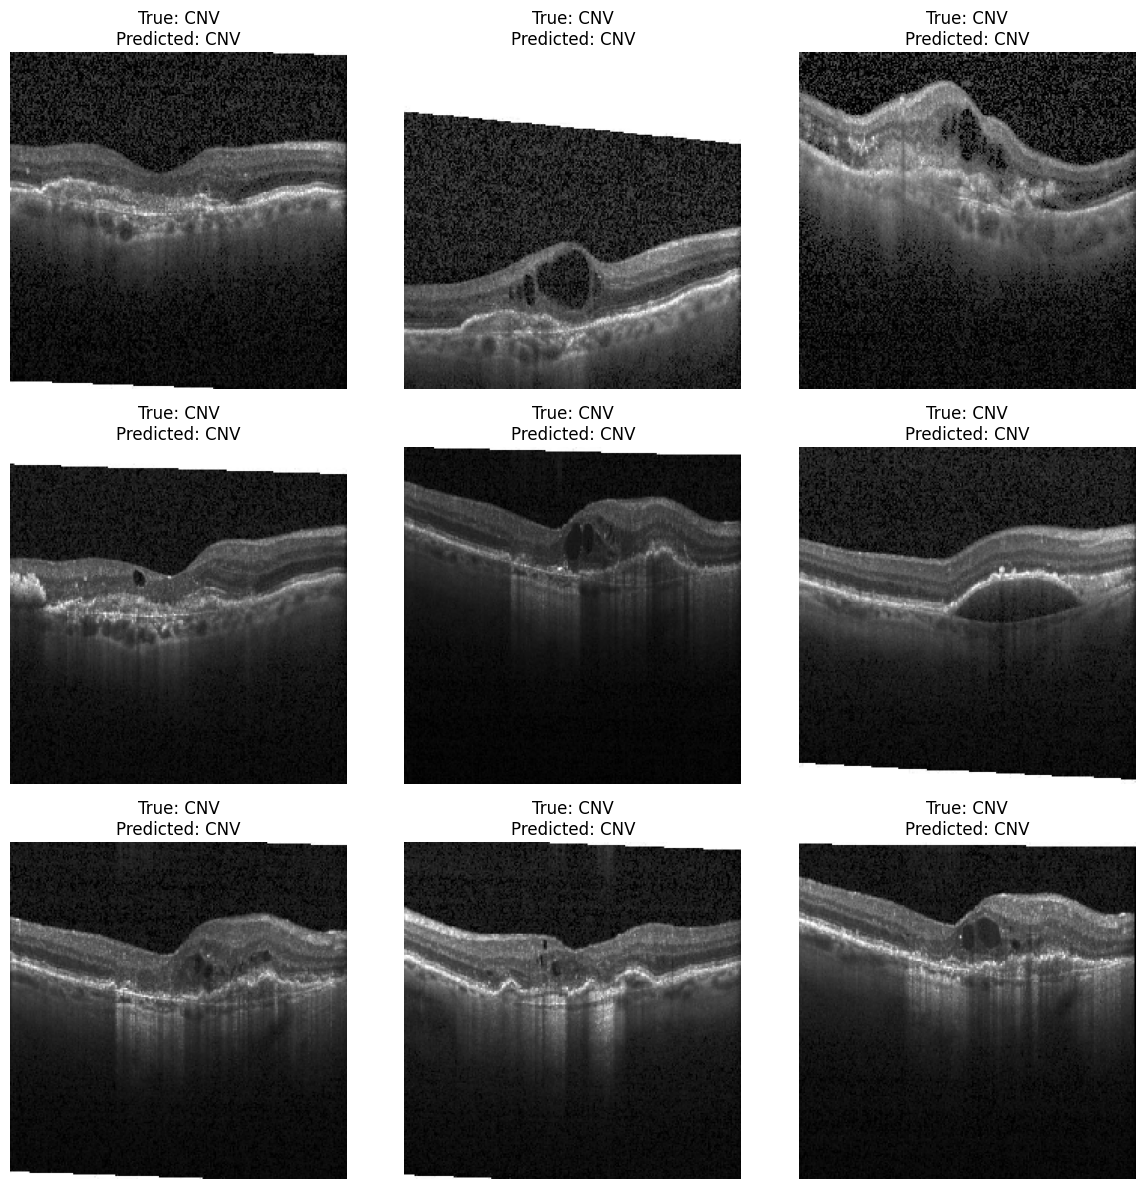

In [10]:
def predict_on_sample(generator, model, class_labels):
    # Get a batch of images and labels
    images, labels = next(generator)
    true_labels = np.argmax(labels, axis=1)

    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Plot a few samples
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype('uint8'))
        true_label = class_labels[true_labels[i]]
        predicted_label = class_labels[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Predict and visualize DenseNet results
predict_on_sample(test_generator, densenet_model, class_labels)
